Stacks encontrados: 202
Ejemplo: plot_100_stack.tif
Procesados 20/202...
Procesados 40/202...
Procesados 60/202...
Procesados 80/202...
Procesados 100/202...
Procesados 120/202...
Procesados 140/202...
Procesados 160/202...
Procesados 180/202...
Procesados 200/202...
LISTO ✅
Salida: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_masked_20251210
Otsu (min/mean/max): 0.23935192823410034 0.4164620378967559 0.643836498260498


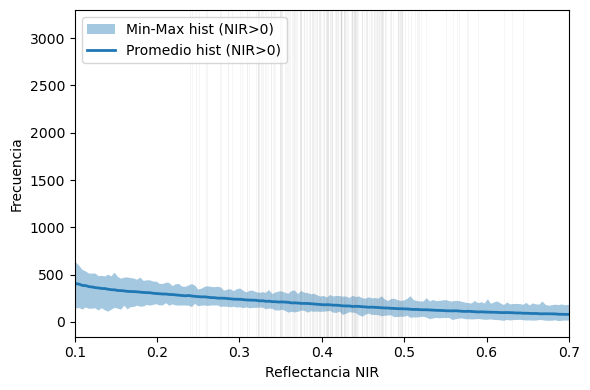

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.filters import threshold_otsu

# =========================
# CONFIG (CAMBIA AQUÍ)
# =========================
stack_dir = r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210"
out_dir   = r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_masked_20251210"
os.makedirs(out_dir, exist_ok=True)

# Orden esperado: B,G,R,RE,NIR -> NIR index = 5 (en rasterio las bandas son 1..5)
NIR_BAND_INDEX = 5

# Histograma
histogram_bins = 256
histogram_range = (0.0, 1.0)   # reflectancia típica; si tus valores pasan 1, te lo ajusto

# Nodata fallback si no viene definido
FILL_NODATA = -9999.0

# =========================
# LISTA DE STACKS
# =========================
files = sorted([f for f in os.listdir(stack_dir) if f.endswith("_stack.tif")])
num_plots = len(files)

print("Stacks encontrados:", num_plots)
print("Ejemplo:", files[0] if num_plots else "NINGUNO")

# =========================
# ACUMULADORES
# =========================
otsu_thresholds = []

accumulated_non_zero_hist = np.zeros(histogram_bins, dtype=np.float64)
accumulated_all_hist      = np.zeros(histogram_bins, dtype=np.float64)

individual_non_zero_hists = []
bin_edges_non_zero = None

# =========================
# LOOP POR PLOT
# =========================
for idx, fname in enumerate(files, start=1):
    in_path = os.path.join(stack_dir, fname)
    plot_id = fname.replace("plot_", "").replace("_stack.tif", "")

    out_mask_path   = os.path.join(out_dir, f"plot_{plot_id}_mask.tif")
    out_masked_path = os.path.join(out_dir, f"plot_{plot_id}_stack_masked.tif")

    with rasterio.open(in_path) as src:
        meta = src.meta.copy()
        nodata = src.nodata

        if nodata is None:
            nodata = FILL_NODATA

        nir = src.read(NIR_BAND_INDEX).astype(np.float32)

        # valores válidos: finitos y != nodata
        valid = np.isfinite(nir) & (nir != nodata)
        nir_valid = nir[valid]

        # histograma "all" (incluye ceros/valores bajos, pero excluye nodata)
        if nir_valid.size > 0:
            hist_all, bin_edges_all = np.histogram(nir_valid, bins=histogram_bins, range=histogram_range)
            accumulated_all_hist += hist_all

        # histograma "non-zero" (excluye 0 para Otsu como el notebook original)
        nir_non_zero = nir_valid[nir_valid > 0]

        if nir_non_zero.size > 0:
            hist_nz, bin_edges_nz = np.histogram(nir_non_zero, bins=histogram_bins, range=histogram_range)
            accumulated_non_zero_hist += hist_nz
            individual_non_zero_hists.append(hist_nz)
            bin_edges_non_zero = bin_edges_nz
        else:
            # si no hay valores >0, guarda hist vacío
            individual_non_zero_hists.append(np.zeros(histogram_bins))
            if bin_edges_non_zero is None:
                bin_edges_non_zero = np.linspace(histogram_range[0], histogram_range[1], histogram_bins + 1)

        # OTSU sobre NIR no-cero
        if nir_non_zero.size > 50:
            thr = float(threshold_otsu(nir_non_zero))
        else:
            thr = 0.0

        otsu_thresholds.append(thr)

        # Máscara: vegetación = 1 (nir > thr), suelo = 0
        veg_mask = (nir > thr).astype(np.uint8)
        veg_mask[~valid] = 0  # nodata -> 0

        # Guardar máscara 1-banda
        mask_meta = meta.copy()
        mask_meta.update({"count": 1, "dtype": "uint8", "nodata": 0, "compress": "DEFLATE"})
        with rasterio.open(out_mask_path, "w", **mask_meta) as dst:
            dst.write(veg_mask, 1)

        # Guardar stack enmascarado (suelo -> nodata)
        masked_meta = meta.copy()
        masked_meta.update({"dtype": "float32", "nodata": nodata, "compress": "DEFLATE"})

        with rasterio.open(out_masked_path, "w", **masked_meta) as dst:
            for b in range(1, src.count + 1):
                band = src.read(b).astype(np.float32)
                band[(veg_mask == 0)] = nodata
                dst.write(band, b)

    if idx % 20 == 0:
        print(f"Procesados {idx}/{num_plots}...")

print("LISTO ✅")
print("Salida:", out_dir)
print("Otsu (min/mean/max):", np.min(otsu_thresholds), np.mean(otsu_thresholds), np.max(otsu_thresholds))

# =========================
# PLOT HISTOGRAMA PROMEDIO + RANGO
# =========================
avg_hist = accumulated_non_zero_hist / max(num_plots, 1)

max_hist = np.max(np.vstack(individual_non_zero_hists), axis=0)
min_hist = np.min(np.vstack(individual_non_zero_hists), axis=0)

plt.figure(figsize=(6, 4))

# líneas Otsu
for t in otsu_thresholds:
    plt.axvline(t, color="gray", linewidth=0.6, alpha=0.08)

# rango min-max
plt.fill_between(bin_edges_non_zero[:-1], min_hist, max_hist, alpha=0.4, label="Min-Max hist (NIR>0)")

# promedio
plt.plot(bin_edges_non_zero[:-1], avg_hist, linewidth=2, label="Promedio hist (NIR>0)")

plt.xlim(0.1, 0.7)
plt.xlabel("Reflectancia NIR")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()
